In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=5
%env DWAVE_API_TOKEN=4Fq8-98e991a786ff04f4f4b6ab5466629411358ce418
%config InlineBackend.figure_format = 'retina'
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: DWAVE_API_TOKEN=4Fq8-98e991a786ff04f4f4b6ab5466629411358ce418
Fri Apr  4 03:02:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:1B:00.0 Off |                  Off |
| 30%   60C    P2            124W /  300W |   37268MiB /  49140MiB |    100%      Default |
|                                      

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/CaloQVAE/')

#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/fast_scratch_1/caloqvae/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/fast_scratch_1/caloqvae/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/fast_scratch_1/caloqvae/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

[03:02:38.397] INFO   CaloQVAE                                          Willkommen!
[03:02:38.399] INFO   CaloQVAE                                          Loading configuration.
[03:02:39.933] INFO   numexpr.utils                                     Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[03:02:39.935] INFO   numexpr.utils                                     Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[03:02:39.936] INFO   numexpr.utils                                     NumExpr defaulting to 8 threads.
2025-04-04 03:02:40,660 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[03:02:40.660] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [3]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")
# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
config.model.n_layers_per_subdec = 15
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/usr/local/lib/python3.10/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[03:02:43.490] INFO   data.dataManager                                  Loading Data
[03:03:05.900] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fc941f69b70>: 80000 events, 625 batches
[03:03:05.903] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fca0079fee0>: 10000 events, 10 batches
[03:03:05.904] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fc9ff0c5390>: 10000 events, 10 batches
[03:03:08.241] INFO   models.modelCreator                               Initialising Model Type AtlasConditionalQVAE3DHD
2025-04-04 03:03:08,253 dw

Initializing NetworkV3
Layer Inputs:  [1208, 3368, 3368, 3368]
Layer Outputs:  [2160, 2160, 2160, 6480]
Raw Layer Indices:  [0, 2160, 2160, 2160, 6480]
Initializing NetworkV3
Initializing NetworkV3
Initializing NetworkV3
Initializing NetworkV3


In [4]:
# dev = torch.device("cuda:0")
dev = "cuda:{0}".format(config.gpu_list[0])
wandb.watch(model)
engine=instantiate(config.engine, config)
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[03:03:12.431] INFO   wandb                                             Watching
/home/luian1/.local/lib/python3.10/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[03:03:13.098] INFO   engine.engineAtlas                                Setting up engine Atlas.
[03:03:13.099] INFO   engine.engineCaloV3                               Setting up engine Calo.
[03:03:13.099] INFO   engine.engine                                     Setting up default engine.


In [5]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[03:03:33.166] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fc89c32b790>: 80000 events, 625 batches
[03:03:33.167] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fc89c32b730>: 10000 events, 10 batches
[03:03:33.168] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fc89c32b8e0>: 10000 events, 10 batches


In [6]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            print(local_module_keys)
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])

import sys
sys.path.append('/path/to/project')

import utils.plotting.HighLevelFeatures as HLF
import h5py
from ipynb.fs.full.utils.plotting.HEPMetrics import get_fpd_kpd_metrics

In [7]:
def search_HEPMetric(path_head, model_name, start_epoch, end_epoch, epoch_int):
    en_list = []
    fpd_recon, fpd_sample = [], []
    kpd_recon, kpd_sample = [], []
    hlf, ref_hlf = None, None
    for en in range(start_epoch, end_epoch, epoch_int):
        run_path = path_head + str(en) + ".pth"
        modelname = model_name
        datascaled = 'reduced'
        open_path = path_head.replace(path_head.split('/')[-1], '') + "config.yaml"
        with open(open_path, 'r') as file:
            model_config = yaml.safe_load(file)
            R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
            reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
            scaled=False
            
        arch = config['model']['model_type']
        part = config['data']['particle_type']
        modelCreator.load_state(run_path, dev)
        engine.model.eval();

        # get the samples
        xtarget_samples = []
        xrecon_samples = []
        xgen_samples = []
        xgen_samples_qpu = []
        n_samples4_qpu = 200
        
        # xrecon_samples_2 = []
        
        # labelstarget_samples = []
        # labelsrecon_samples = []
        entarget_samples = []
        with torch.no_grad():
            for xx in train_loader:
            # for xx in train_loader:
                in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
                ###############################################
                # true_energy = true_energy[:n_samples4_qpu,:]
                # in_data = in_data[:n_samples4_qpu,:]
                ##############################################
                # print(in_data.shape)
                if reducedata:
                    in_data = engine._reduce(in_data, true_energy, R=R)
                fwd_output = engine.model((in_data, true_energy), False)
                if reducedata:
                    in_data = engine._reduceinv(in_data, true_energy, R=R)
                    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy, num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
                    # sample_data_qpu = engine._reduceinv(sample_data_qpu, sample_energies_qpu, R=R)
                elif scaled:
                    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
                    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_just_act.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_energy_shift.detach().cpu().numpy()))
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy[:100,:], num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
                    # sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
                else:
                    in_data = in_data.detach().cpu()*1000
                    recon_data = fwd_output.output_activations.detach().cpu()*1000
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
                    sample_data = sample_data.detach().cpu()*1000
        
        
                xtarget_samples.append(in_data.detach().cpu())
                xrecon_samples.append( recon_data.detach().cpu())
                xgen_samples.append( sample_data.detach().cpu())
                # xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
                entarget_samples.append(true_energy.detach().cpu())
        
                # xrecon_samples_2.append( recon_data_2.detach().cpu())
            for xx in val_loader:
            # for xx in train_loader:
                in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
                ###############################################
                # true_energy = true_energy[:n_samples4_qpu,:]
                # in_data = in_data[:n_samples4_qpu,:]
                ##############################################
                # print(in_data.shape)
                if reducedata:
                    in_data = engine._reduce(in_data, true_energy, R=R)
                fwd_output = engine.model((in_data, true_energy), False)
                if reducedata:
                    in_data = engine._reduceinv(in_data, true_energy, R=R)
                    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy, num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
                    # sample_data_qpu = engine._reduceinv(sample_data_qpu, sample_energies_qpu, R=R)
                elif scaled:
                    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
                    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_just_act.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_energy_shift.detach().cpu().numpy()))
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy[:100,:], num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
                    # sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
                else:
                    in_data = in_data.detach().cpu()*1000
                    recon_data = fwd_output.output_activations.detach().cpu()*1000
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
                    sample_data = sample_data.detach().cpu()*1000
        
        
                xtarget_samples.append(in_data.detach().cpu())
                xrecon_samples.append( recon_data.detach().cpu())
                xgen_samples.append( sample_data.detach().cpu())
                # xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
                entarget_samples.append(true_energy.detach().cpu())
        
                # xrecon_samples_2.append( recon_data_2.detach().cpu())
            for xx in test_loader:
            # for xx in train_loader:
                in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
                ###############################################
                # true_energy = true_energy[:n_samples4_qpu,:]
                # in_data = in_data[:n_samples4_qpu,:]
                ##############################################
                # print(in_data.shape)
                if reducedata:
                    in_data = engine._reduce(in_data, true_energy, R=R)
                fwd_output = engine.model((in_data, true_energy), False)
                if reducedata:
                    in_data = engine._reduceinv(in_data, true_energy, R=R)
                    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy, num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
                    # sample_data_qpu = engine._reduceinv(sample_data_qpu, sample_energies_qpu, R=R)
                elif scaled:
                    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
                    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_just_act.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_energy_shift.detach().cpu().numpy()))
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy[:100,:], num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
                    # sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
                else:
                    in_data = in_data.detach().cpu()*1000
                    recon_data = fwd_output.output_activations.detach().cpu()*1000
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
                    sample_data = sample_data.detach().cpu()*1000
        
        
                xtarget_samples.append(in_data.detach().cpu())
                xrecon_samples.append( recon_data.detach().cpu())
                xgen_samples.append( sample_data.detach().cpu())
                # xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
                entarget_samples.append(true_energy.detach().cpu())
        
                # xrecon_samples_2.append( recon_data_2.detach().cpu())
            
            
        xtarget_samples = torch.cat(xtarget_samples, dim=0)
        xrecon_samples = torch.cat(xrecon_samples, dim=0)
        xgen_samples = torch.cat(xgen_samples, dim=0)
        # xgen_samples_qpu = torch.cat(xgen_samples_qpu, dim=0)
        entarget_samples = torch.cat(entarget_samples, dim=0)
        
        # xrecon_samples_2 = torch.cat(xrecon_samples_2, dim=0)
        if en == start_epoch:
            print("First epoch")
            hlf = HLF.HighLevelFeatures('electron', filename='/fast_scratch_1/caloqvae/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)
            ref_hlf = HLF.HighLevelFeatures('electron', filename='/fast_scratch_1/caloqvae/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)
            hlf.Einc = entarget_samples

        recon_HEPMetrics = get_fpd_kpd_metrics(np.array(xtarget_samples), np.array(xrecon_samples), False, hlf, ref_hlf)
        sample_HEPMetrics = get_fpd_kpd_metrics(np.array(xtarget_samples), np.array(xgen_samples), False, hlf, ref_hlf)

        en_list.append(en)
        fpd_recon.append(recon_HEPMetrics[0])
        kpd_recon.append(recon_HEPMetrics[2])
        fpd_sample.append(sample_HEPMetrics[0])
        kpd_sample.append(sample_HEPMetrics[2])
        print("Finished generating HEP Metrics for epoch " + str(en) + " ...")
    return en_list, fpd_recon, kpd_recon, fpd_sample, kpd_sample

In [8]:
path_head = "/fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_"
model_name = 'good-haze-675'
HEPMetric_output = search_HEPMetric(path_head, model_name, 10, 201, 10)

[03:03:33.687] INFO   models.modelCreator                               Loading state
[03:03:34.069] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_10.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
First epoch
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 281.7190 ± 0.9886
KPD (x10^3): 0.8925 ± 0.1293
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[03:18:42.003] INFO   models.modelCreator                               Loading state


FPD (x10^3): 480.9677 ± 1.3099
KPD (x10^3): 1.2446 ± 0.2023
Finished generating HEP Metrics for epoch 10 ...


[03:18:42.449] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_20.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 276.1011 ± 3.0006
KPD (x10^3): 1.7953 ± 0.3256
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[03:33:55.353] INFO   models.modelCreator                               Loading state


FPD (x10^3): 371.8109 ± 2.5001
KPD (x10^3): 1.0139 ± 0.1792
Finished generating HEP Metrics for epoch 20 ...


[03:33:56.052] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_30.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 236.2391 ± 1.1413
KPD (x10^3): 1.0430 ± 0.3626
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[03:49:30.803] INFO   models.modelCreator                               Loading state


FPD (x10^3): 376.5017 ± 1.7648
KPD (x10^3): 1.2325 ± 0.2424
Finished generating HEP Metrics for epoch 30 ...


[03:49:31.220] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_40.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 221.0745 ± 1.0064
KPD (x10^3): 0.9093 ± 0.1652
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[04:04:44.355] INFO   models.modelCreator                               Loading state


FPD (x10^3): 347.9505 ± 1.9038
KPD (x10^3): 0.8620 ± 0.0979
Finished generating HEP Metrics for epoch 40 ...


[04:04:44.862] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_50.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 186.4442 ± 0.8584
KPD (x10^3): 0.4692 ± 0.1613
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[04:20:04.674] INFO   models.modelCreator                               Loading state


FPD (x10^3): 345.9666 ± 2.1094
KPD (x10^3): 0.5747 ± 0.0485
Finished generating HEP Metrics for epoch 50 ...


[04:20:05.039] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_60.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 203.0007 ± 2.1686
KPD (x10^3): 0.9736 ± 0.1041
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[04:36:01.767] INFO   models.modelCreator                               Loading state


FPD (x10^3): 447.1062 ± 3.1354
KPD (x10^3): 1.3796 ± 0.1824
Finished generating HEP Metrics for epoch 60 ...


[04:36:02.224] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_70.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 212.4961 ± 2.5826
KPD (x10^3): 1.6467 ± 0.4304
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[04:51:30.636] INFO   models.modelCreator                               Loading state


FPD (x10^3): 408.5055 ± 2.2809
KPD (x10^3): 1.4674 ± 0.4328
Finished generating HEP Metrics for epoch 70 ...


[04:51:30.967] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_80.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 163.9223 ± 1.2297
KPD (x10^3): 0.5485 ± 0.1941
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[05:07:19.968] INFO   models.modelCreator                               Loading state


FPD (x10^3): 380.3159 ± 2.0602
KPD (x10^3): 0.7810 ± 0.0842
Finished generating HEP Metrics for epoch 80 ...


[05:07:20.288] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_90.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 143.8948 ± 1.7074
KPD (x10^3): 0.6028 ± 0.2088
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[05:23:13.531] INFO   models.modelCreator                               Loading state


FPD (x10^3): 325.7682 ± 1.7317
KPD (x10^3): 0.3853 ± 0.0963
Finished generating HEP Metrics for epoch 90 ...


[05:23:14.156] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_100.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 156.7035 ± 2.2803
KPD (x10^3): 0.7563 ± 0.1997
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[05:38:58.217] INFO   models.modelCreator                               Loading state


FPD (x10^3): 370.9498 ± 2.5427
KPD (x10^3): 0.6920 ± 0.1563
Finished generating HEP Metrics for epoch 100 ...


[05:38:58.772] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_110.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 149.1676 ± 1.9097
KPD (x10^3): 0.8839 ± 0.3418
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[05:54:42.094] INFO   models.modelCreator                               Loading state


FPD (x10^3): 388.8937 ± 2.8222
KPD (x10^3): 1.0034 ± 0.2388
Finished generating HEP Metrics for epoch 110 ...


[05:54:42.531] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_120.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 97.0663 ± 1.4957
KPD (x10^3): 0.4193 ± 0.1218
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[06:10:42.914] INFO   models.modelCreator                               Loading state


FPD (x10^3): 288.1158 ± 1.6173
KPD (x10^3): 0.4393 ± 0.0761
Finished generating HEP Metrics for epoch 120 ...


[06:10:43.663] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_130.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 96.1007 ± 0.8357
KPD (x10^3): 0.2051 ± 0.0500
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[06:26:33.102] INFO   models.modelCreator                               Loading state


FPD (x10^3): 322.4109 ± 1.6066
KPD (x10^3): 0.5984 ± 0.1189
Finished generating HEP Metrics for epoch 130 ...


[06:26:34.009] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_140.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 109.3599 ± 1.5862
KPD (x10^3): 0.8647 ± 0.3186
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[06:42:05.134] INFO   models.modelCreator                               Loading state


FPD (x10^3): 327.5361 ± 2.0596
KPD (x10^3): 0.8815 ± 0.1815
Finished generating HEP Metrics for epoch 140 ...


[06:42:05.572] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_150.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 107.7773 ± 1.8316
KPD (x10^3): 0.3581 ± 0.2553
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[06:58:00.597] INFO   models.modelCreator                               Loading state


FPD (x10^3): 259.4261 ± 1.8746
KPD (x10^3): 0.2395 ± 0.0733
Finished generating HEP Metrics for epoch 150 ...


[06:58:01.062] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_160.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 79.8844 ± 1.6735
KPD (x10^3): 0.5343 ± 0.2400
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[07:14:00.521] INFO   models.modelCreator                               Loading state


FPD (x10^3): 287.6938 ± 2.1975
KPD (x10^3): 0.6621 ± 0.1071
Finished generating HEP Metrics for epoch 160 ...


[07:14:01.145] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_170.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 114.2616 ± 2.3559
KPD (x10^3): 0.7419 ± 0.2714
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[07:29:45.072] INFO   models.modelCreator                               Loading state


FPD (x10^3): 256.4995 ± 2.4515
KPD (x10^3): 0.5167 ± 0.0949
Finished generating HEP Metrics for epoch 170 ...


[07:29:45.719] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_180.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 79.6326 ± 1.1106
KPD (x10^3): 0.2246 ± 0.1065
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[07:45:56.159] INFO   models.modelCreator                               Loading state


FPD (x10^3): 249.9820 ± 2.2889
KPD (x10^3): 0.4181 ± 0.0791
Finished generating HEP Metrics for epoch 180 ...


[07:45:56.606] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_190.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 75.0136 ± 0.7919
KPD (x10^3): 0.4275 ± 0.1114
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[08:01:46.600] INFO   models.modelCreator                               Loading state


FPD (x10^3): 227.3236 ± 1.7460
KPD (x10^3): 0.4804 ± 0.0382
Finished generating HEP Metrics for epoch 190 ...


[08:01:47.133] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250326_172648-1jifk4nt/files/AtlasConditionalQVAE3DHD_atlas_default_200.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 102.6922 ± 1.6439
KPD (x10^3): 0.7902 ± 0.4950
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 263.0711 ± 1.6972
KPD (x10^3): 0.7912 ± 0.3434
Finished generating HEP Metrics for epoch 200 ...


[0.28171901775261654, 0.27610111297952855, 0.23623908580388636, 0.2210744808510937, 0.18644421826289684, 0.2030007466602672, 0.21249611874140645, 0.16392233757991367, 0.14389478161185731, 0.15670347982957408, 0.14916755955246316, 0.09706627397032931, 0.09610074953743804, 0.10935985550777683, 0.1077773271212027, 0.07988435220504599, 0.1142615911016994, 0.07963256980948644, 0.0750136093510446, 0.10269223549619816] [0.000892549225344208, 0.0017953303946163235, 0.0010429697587919229, 0.0009093175006329446, 0.0004692477270269446, 0.0009735575941149932, 0.0016466744829819469, 0.0005484693821053988, 0.0006027670358537129, 0.0007562910841800718, 0.0008838656391592092, 0.0004192771768365411, 0.00020511683985757756, 0.0008646527921194469, 0.0003581094360560755, 0.0005342887399362173, 0.0007419315984997787, 0.0002245765988551085, 0.00042751229226900556, 0.0007902208080936557] [0.48096773085005806, 0.3718108700088141, 0.37650166790362044, 0.3479505446097048, 0.34596658390872476, 0.4471061780129338

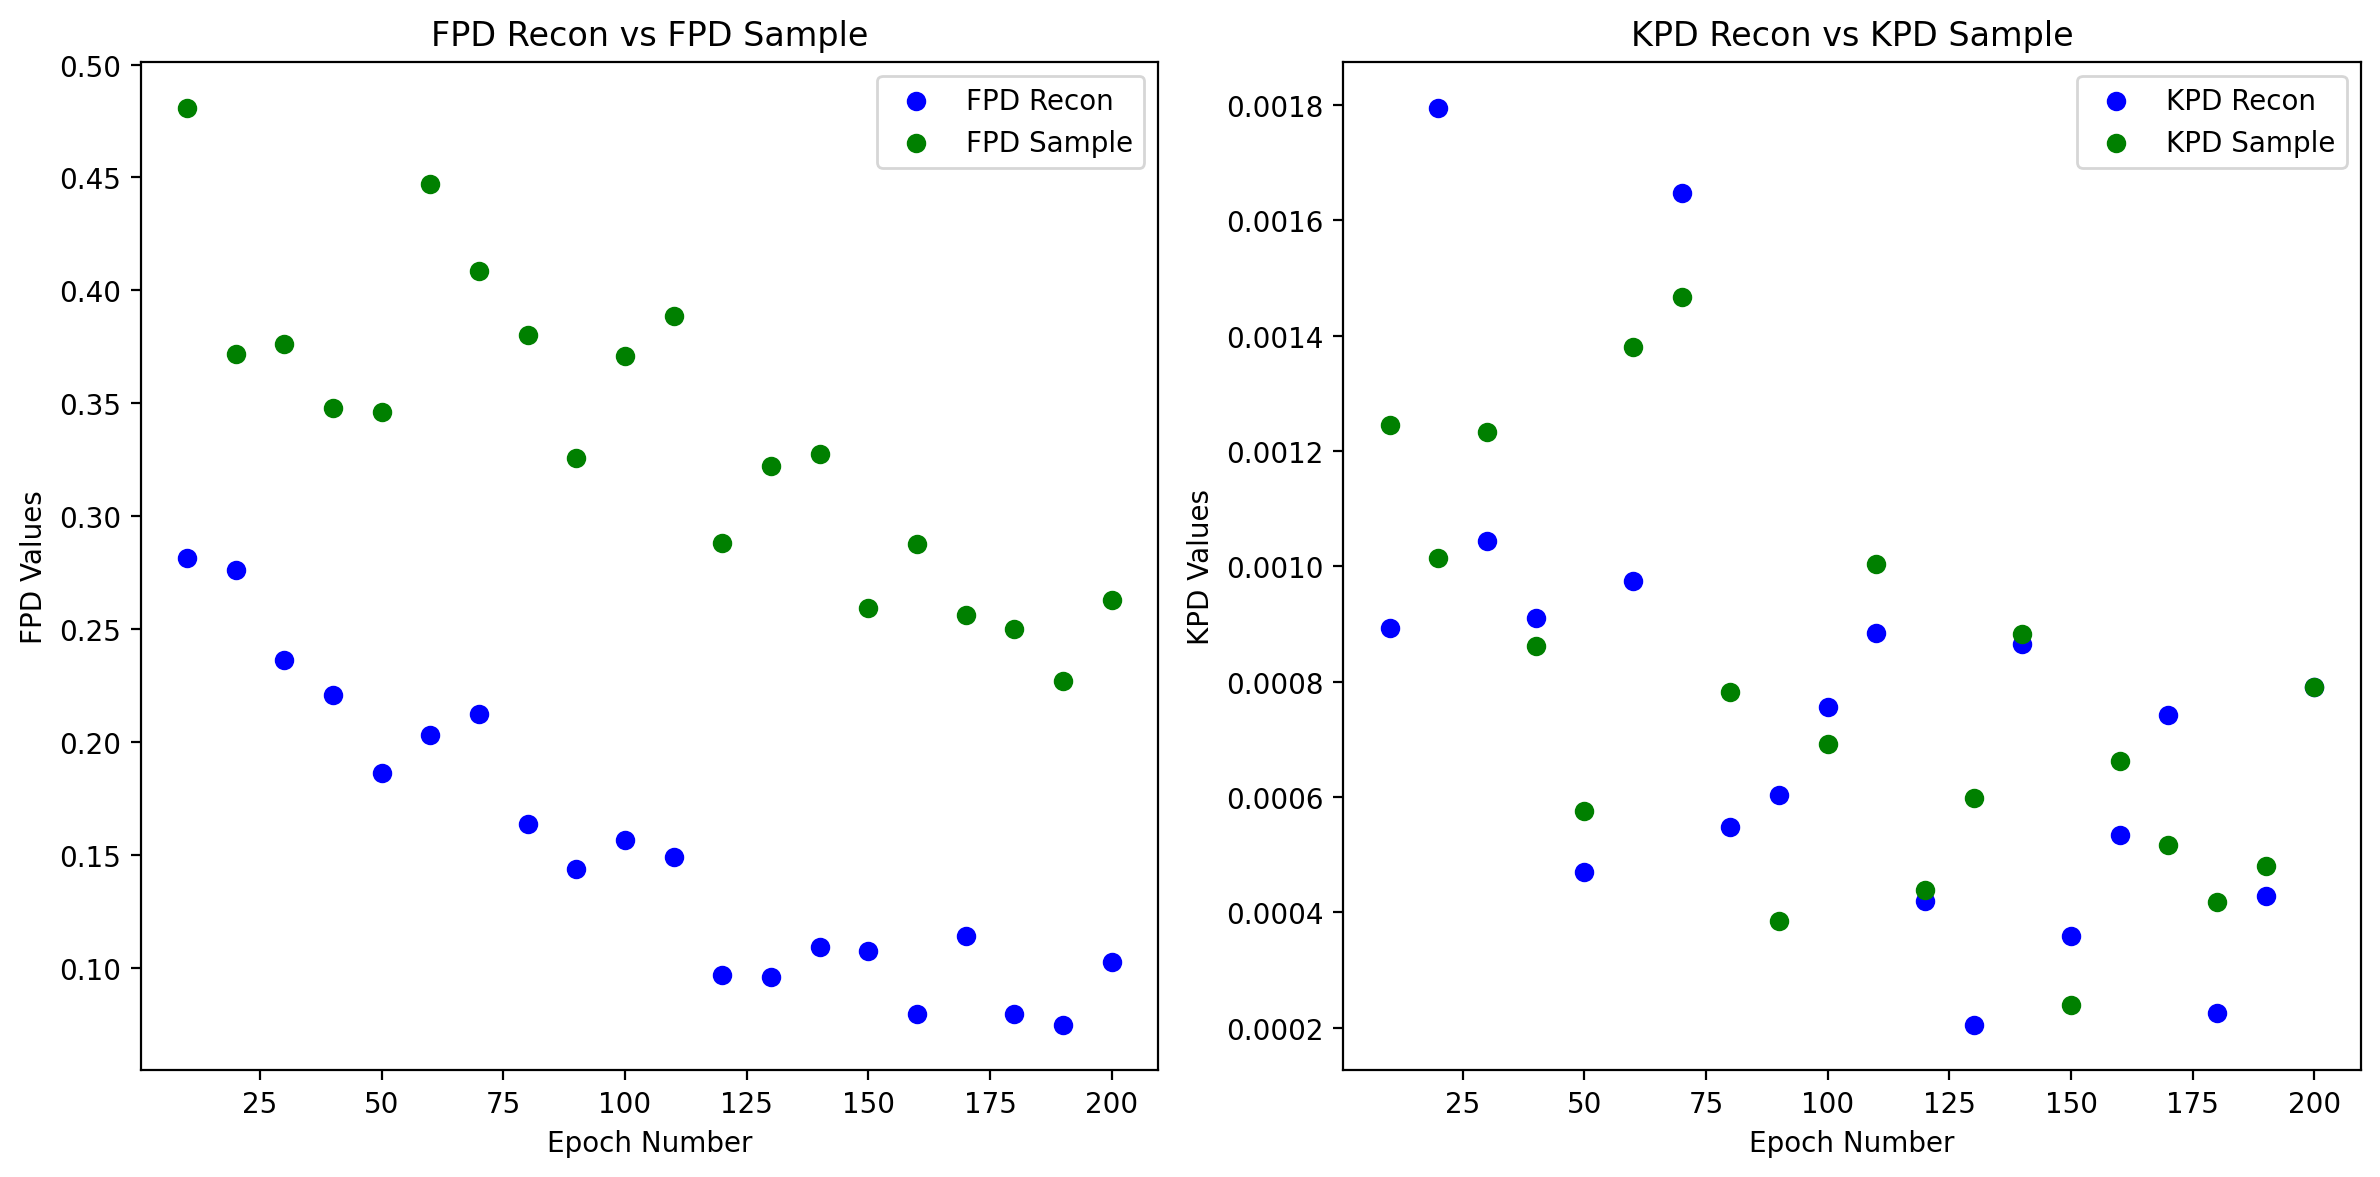

In [9]:
import matplotlib.pyplot as plt

en_list, fpd_recon, kpd_recon, fpd_sample, kpd_sample = HEPMetric_output[0], HEPMetric_output[1], HEPMetric_output[2], HEPMetric_output[3], HEPMetric_output[4]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

print(fpd_recon, kpd_recon, fpd_sample, kpd_sample)

# Plot fpd_recon and fpd_sample on ax1
ax1.scatter(en_list, fpd_recon, color='blue', label='FPD Recon')
ax1.scatter(en_list, fpd_sample, color='green', label='FPD Sample')
ax1.set_xlabel('Epoch Number')
ax1.set_ylabel('FPD Values')
ax1.set_title('FPD Recon vs FPD Sample')
ax1.legend()

# Plot kpd_recon and kpd_sample on ax2
ax2.scatter(en_list, kpd_recon, color='blue', label='KPD Recon')
ax2.scatter(en_list, kpd_sample, color='green', label='KPD Sample')
ax2.set_xlabel('Epoch Number')
ax2.set_ylabel('KPD Values')
ax2.set_title('KPD Recon vs KPD Sample')
ax2.legend()

plt.tight_layout()
plt.show()